# Training quantum kernels for 2-classes classification tasks.

## Packages importing 

In [1]:
import numpy as np

# importing Qiskit
from qiskit import assemble, transpile
from qiskit.quantum_info import Statevector, Operator
import qiskit.quantum_info as qi
from qiskit.circuit.library import PauliFeatureMap, ZZFeatureMap
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit, QuantumRegister, ClassicalRegister

# import basic plot tools
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# importing Qiskit ML
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

# Importing Sklearn 
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.model_selection import train_test_split

## Data with batches preparation 

In [2]:
def data_prep(dataset):
    X_train, X_test, y_train, y_test = dataset 

    # Separated class preparation
    class_1 = [i for i in range(0,len(y_train)) if y_train[i]==0]
    class_2 = [i for i in range(0,len(y_train)) if y_train[i]==1]
    X_train = np.array([X_train[x] for x in (class_1+class_2)])
    y_train = np.array([y_train[x] for x in (class_1+class_2)])

    class_1_test = [i for i in range(0,len(y_test)) if y_test[i]==0]
    class_2_test = [i for i in range(0,len(y_test)) if y_test[i]==1]
    X_test = np.array([X_test[x] for x in (class_1_test+class_2_test)])
    y_test = np.array([y_test[x] for x in (class_1_test+class_2_test)])

    dataset_prep = X_train, X_test, y_train, y_test
    return dataset_prep

# Generation of the whole dataset
# X, y = make_moons(n_samples=400, noise=0.15, random_state=16)
# X, y = make_circles(n_samples=400, noise=0.1, random_state=16, factor = 0.2)

X, y = make_classification(
    n_samples = 400, n_features=2, n_redundant=0, n_informative=2,
      random_state=3, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += rng.uniform(size=X.shape)


# dataset = train_test_split(X, y, stratify=y, random_state=16)
# arg, _,_,_ = dataset

X_train, X_test, y_train, y_test = data_prep(train_test_split(X, y, stratify=y, random_state=16))
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [3]:
def get_limits(X):
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    return x_min - 0.5, x_max + 0.5, y_min - 0.5, y_max + 0.5
x_min, x_max, y_min, y_max = get_limits(X)
x_min, x_max, y_min, y_max

(-2.381085309669609, 4.225935291156302, -2.143380343035548, 3.0942201062683656)

In [4]:
class_size = int(len(X_train)/2)
class_size

150

In [5]:
X_train_1 = X_train[:class_size]
y_train_1 = y_train[:class_size]
X_train_2 = X_train[class_size:]
y_train_2 = y_train[class_size:]

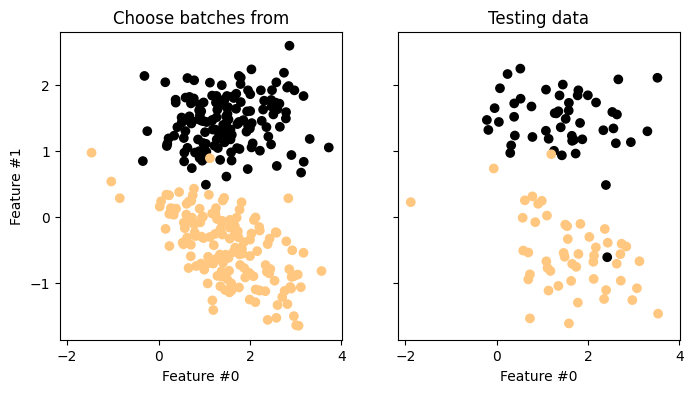

In [6]:
# Plotting the results
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='copper')
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Choose batches from")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='copper')
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [7]:
import random
batch_size = 4
N_batches = 5

def create_batches(data1, data2, n):
    batch_list = []
    for i in range(n):
        batch_list.append((random.choices(data1, k=batch_size),random.choices(data2, k=batch_size)))
    return batch_list

batch_list = create_batches(X_train_1, X_train_2, N_batches)
batch_list[0]

([array([1.6962866 , 1.63942688]),
  array([1.80020965, 1.74101312]),
  array([2.64591591, 1.71756015]),
  array([0.37646436, 1.73330447])],
 [array([ 1.25876095, -0.63339981]),
  array([0.61467606, 0.20114832]),
  array([ 1.08470105, -0.59987976]),
  array([0.60858802, 0.0382919 ])])

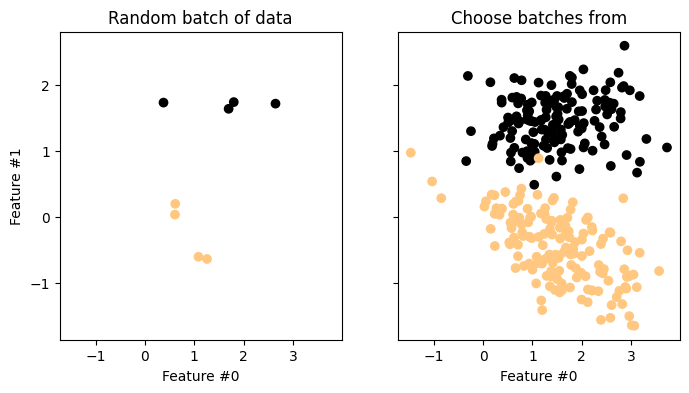

In [9]:
# Plotting the results
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(np.array(batch_list[0]).reshape(-1)[::2],np.array(batch_list[0]).reshape(-1)[1::2],
                  c=[0,0,0,0,1,1,1,1], cmap='copper')
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Random batch of data")


test_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='copper')
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Choose batches from")

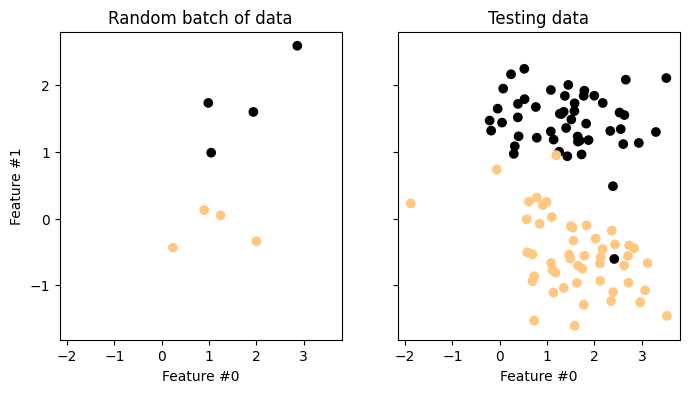

In [ ]:
# Plotting the results
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(np.array(batch_list[0]).reshape(-1)[::2],np.array(batch_list[0]).reshape(-1)[1::2],
                  c=[0,0,0,0,1,1,1,1], cmap='copper')
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Random batch of data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='copper')
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

## Model as a class

In [ ]:
def hs_dist(rho,sigma):
  return np.trace(np.matmul(rho,rho) - 2*np.matmul(rho,sigma) + np.matmul(sigma,sigma))

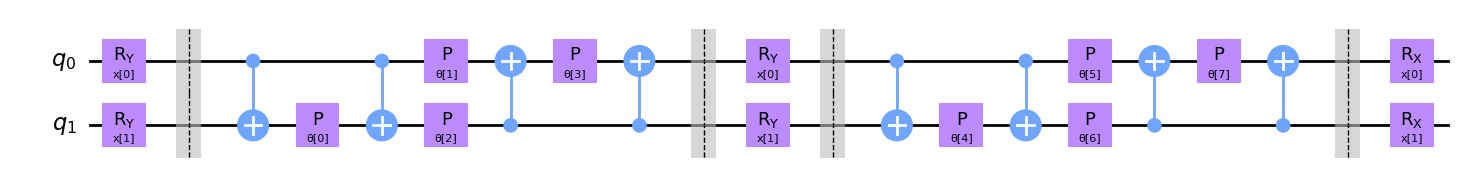

In [ ]:
M = 2
layer_par_n = 4
layers_n = 2

theta_list = ParameterVector('θ', length = layer_par_n*layers_n)
data_list  = ParameterVector('x', length = M)


def make_circuit(layers_n):
    
    M = 2
    layer_par_n = 4
    circuit = QuantumCircuit(M)

    for layer in range(layers_n):
        
        for k in range(M):
            circuit.ry(data_list[k],k) 
        circuit.barrier()

        circuit.cx(0,1) 
        circuit.p(theta_list[layer*layer_par_n],1) 
        circuit.cx(0,1)  

        circuit.p(theta_list[layer*layer_par_n + 1],0) 
        circuit.p(theta_list[layer*layer_par_n + 2],1)

        circuit.cx(1,0) 
        circuit.p(theta_list[layer*layer_par_n + 3],0) 
        circuit.cx(1,0) 
        circuit.barrier()
        
    for k in range(M):
        circuit.rx(data_list[k],k)

    return  circuit

my_circ = make_circuit(layers_n)
my_circ.draw("mpl")


In [ ]:
from scipy.optimize import minimize
from sklearn.svm import SVC  

progress = []
test_results = []
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)

class QTK:

    def __init__(self, data, circuit):
        self.data = data_prep(data)
        self.circuit = circuit

    def cost(self, params):
        circ = self.circuit.assign_parameters({theta_list: params})
        kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=circ)
        outcome = 0
        for batch in batch_list:
            X_train_1 = np.array(batch[0])
            X_train_2 = np.array(batch[1])
            X_train = np.concatenate((X_train_1, X_train_2), axis=0)
            kernel_matrix = kernel.evaluate(x_vec=X_train) / len(X_train)
            rho = kernel.evaluate(x_vec=X_train_1) / (2*len(X_train_1))
            sigma = kernel.evaluate(x_vec=X_train_2) / (2*len(X_train_2))
            separated_matrix = np.kron(np.array([[1,0],[0,0]]), rho) + np.kron(np.array([[0,0],[0,1]]), sigma) 
            hs = hs_dist(separated_matrix, kernel_matrix)
            outcome += hs
        # c1 = 0.5*(1 - 0.5*(np.trace(np.matmul(rho,rho)) + np.trace(np.matmul(sigma,sigma)) - hs)) 
        outcome = outcome/N_batches

        return np.round(outcome,4)
    
    def get_svc(self, params): 
        training_size = 15
        X_train = self.data[0]
        y_train = self.data[2]
        X_train_1 = X_train[:training_size]
        y_train_1 = y_train[:training_size]
        X_train_2 = X_train[class_size:class_size + training_size]
        y_train_2 = y_train[class_size:class_size + training_size]

        X_train = np.concatenate((X_train_1,X_train_2), axis=0)
        y_train = np.concatenate((y_train_1,y_train_2), axis=0)

        kernel = self.circuit.assign_parameters({theta_list: params})
        kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=kernel)
        func = lambda a,b : kernel.evaluate(a,b)
        model_svc = SVC(kernel= func)
        model_svc.fit(X_train, y_train)
        return model_svc
    
    def test_performance(self, params):
        model_svc = self.get_svc(params)
        return model_svc.score(X_test, y_test)
    
    def plot_boundaries(self, coef_t, coef_nt): 

        training_size = 15
        X_train = self.data[0]
        y_train = self.data[2]
        X_train_1 = X_train[:training_size]
        y_train_1 = y_train[:training_size]
        X_train_2 = X_train[class_size:class_size + training_size]
        y_train_2 = y_train[class_size:class_size + training_size]

        X_train = np.concatenate((X_train_1,X_train_2), axis=0)
        y_train = np.concatenate((y_train_1,y_train_2), axis=0)

        model_svc_no_training = self.get_svc(coef_nt)
        model_svc = self.get_svc(coef_t)


        _, axs = plt.subplots(1, 2, figsize=(12, 5))
        h = (x_max - x_min)/20
        xx, yy = np.meshgrid(np.arange(x_min, x_max+h, h), np.arange(y_min, y_max+h, h))

        # just plot the dataset first
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(["#FF0000", "#0000FF"])
        axs[0].scatter(
            X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
        )
        axs[0].set_xlim(x_min, x_max)
        axs[0].set_ylim(y_min, y_max)
        axs[0].set_xticks(())
        axs[0].set_yticks(())
        Z = model_svc_no_training.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        axs[0].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
        axs[0].set_title("Decision boundaries without encoding optimization")

        axs[1].scatter(
            X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
        )
        axs[1].set_xlim(x_min, x_max)
        axs[1].set_ylim(y_min, y_max)
        axs[1].set_xticks(())
        axs[1].set_yticks(())
        Z = model_svc.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        axs[1].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
        axs[1].set_title("Decision boundaries with encoding optimization")

        plt.show()
    
    def callback(self, xk):  
        res = self.cost(xk)
        progress.append(res)
        test = self.test_performance(xk)
        test_results.append(test)
        print("Iteration ", len(progress),": C =  ", res, "Test results ", test, "Parameters: ", xk)
        # print("Iteration ", len(progress),": C =  ", res)

    def train(self, coef):
        out = minimize(self.cost, 
                    x0=coef, 
                    method="COBYLA",
                    callback=self.callback, 
                    options={'maxiter':100})
        return out
    
    def get_results(self, coef_t, coef_nt):
        X_test = self.data[1]
        y_test = self.data[3]

        model_svc = self.get_svc(coef_t)
        model_score_callable_function = model_svc.score(X_test, y_test)

        model_svc_no_training = self.get_svc(coef_nt)
        model_score_callable_function_no_training = model_svc_no_training.score(X_test, y_test)

        # print(f"Callable kernel classification test score: {model_score_callable_function}")
        print(f"Classification Model                        | Accuracy Score")
        print(f"---------------------------------------------------------")
        print(f"Precomputed kernel matrix with training     | {model_score_callable_function:10.2f}")
        print(f"Precomputed kernel matrix without training  | {model_score_callable_function_no_training :10.2f}")
    
    def plot_cost(self): 
        pass

In [ ]:
data = train_test_split(X, y, stratify=y, random_state=3)
my_circ = make_circuit(layers_n)
qtk_model = QTK(data, my_circ)
coef = [1,0,8,0]*layers_n
qtk_model.cost(coef)

0.1562

In [ ]:
out = qtk_model.train(coef)

Iteration  1 : C =   0.2125 Test results  0.92 Parameters:  [2. 0. 8. 0. 1. 0. 8. 0.]
Iteration  2 : C =   0.0766 Test results  0.97 Parameters:  [1. 1. 8. 0. 1. 0. 8. 0.]
Iteration  3 : C =   0.0939 Test results  0.94 Parameters:  [1. 1. 9. 0. 1. 0. 8. 0.]
Iteration  4 : C =   0.1244 Test results  0.91 Parameters:  [1. 1. 8. 1. 1. 0. 8. 0.]
Iteration  5 : C =   0.0526 Test results  0.89 Parameters:  [1. 1. 8. 0. 2. 0. 8. 0.]
Iteration  6 : C =   0.0535 Test results  0.93 Parameters:  [1. 1. 8. 0. 2. 1. 8. 0.]
Iteration  7 : C =   0.0391 Test results  0.97 Parameters:  [1. 1. 8. 0. 2. 0. 9. 0.]
Iteration  8 : C =   0.0751 Test results  0.95 Parameters:  [1. 1. 8. 0. 2. 0. 9. 1.]
Iteration  9 : C =   0.0397 Test results  0.97 Parameters:  [ 0.71748195  1.39943938  7.91318717 -0.23986435  2.12043398 -0.80239141
  9.06774412 -0.18065097]
Iteration  10 : C =   0.0403 Test results  0.92 Parameters:  [ 1.47975569  1.05864406  7.98725449 -0.03521591  2.01768163 -0.11780384
  9.00994592 -0.026

In [ ]:
coef_start = [2., 0., 8., 0., 1., 0., 8., 0.,]
# coef
qtk_model.get_results(out.x, coef_start)

Classification Model                        | Accuracy Score
---------------------------------------------------------
Precomputed kernel matrix with training     |       0.97
Precomputed kernel matrix without training  |       0.85


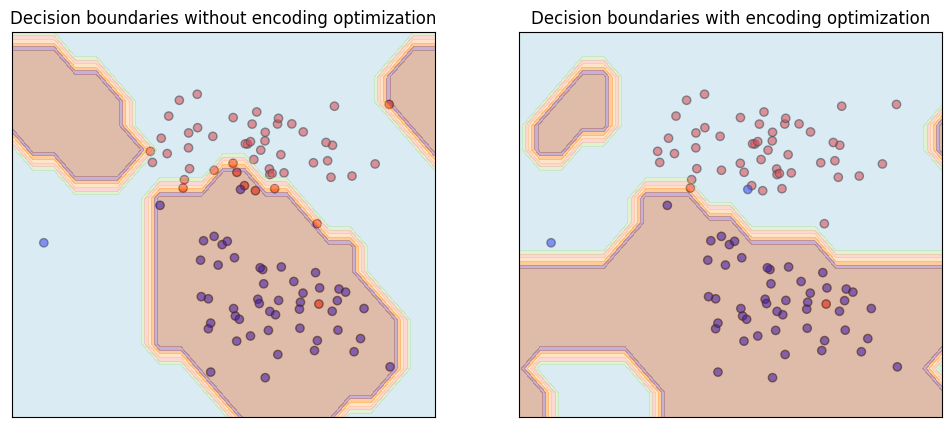

In [ ]:
qtk_model.plot_boundaries(out.x, coef_start)

In [ ]:
coef_nt = [2, 0, 8, 0, 1, 0, 8, 0]
coef_t = out.x
# coef_t = out
# model_svc_no_training = qtk_model.get_svc(coef_nt)
model_svc = qtk_model.get_svc(coef_t)

h = (x_max - x_min)/20
xx, yy = np.meshgrid(np.arange(x_min, x_max+h, h), np.arange(y_min, y_max+h, h))

# Z_nt = model_svc_no_training.predict(np.c_[xx.ravel(), yy.ravel()])
Z_t = model_svc.predict(np.c_[xx.ravel(), yy.ravel()])

In [ ]:
Z_t.shape, xx.shape[0] * xx.shape[1]

((357,), 357)

In [ ]:
def clean_file(file_path):
    with open(file_path, 'w') as file:
        file.write("")

    print("File content cleaned.")
    

# Function to remove lines containing a specific keyword from the file
def remove_lines(file_path, keyword):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Filter out lines containing the specified keyword
    filtered_lines = [line for line in lines if keyword not in line]

    with open(file_path, 'w') as file:
        file.writelines(filtered_lines)

def add_line(file_path, data, pos):
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith(pos):
                print(line.startswith(pos))
                print("Can not add: the position is not empty!")
                return 
    
    with open(file_path, 'a') as file:
        file.write(pos)
        np.savetxt(file, data, newline=' ', fmt='%f')  # Save the array
        file.write("\n")
    print("Successfully added")

In [ ]:
name = 'linear'
file_path = 'results.txt'
# clean_file(file_path)

name_bt = name + '_bt'
remove_lines(file_path, keyword = name_bt)
add_line(file_path, Z_t, name_bt)

# # clean_file('out.txt')
# remove_lines('out.txt', keyword = name)
# add_line('out.txt', out.x, name)

Successfully added


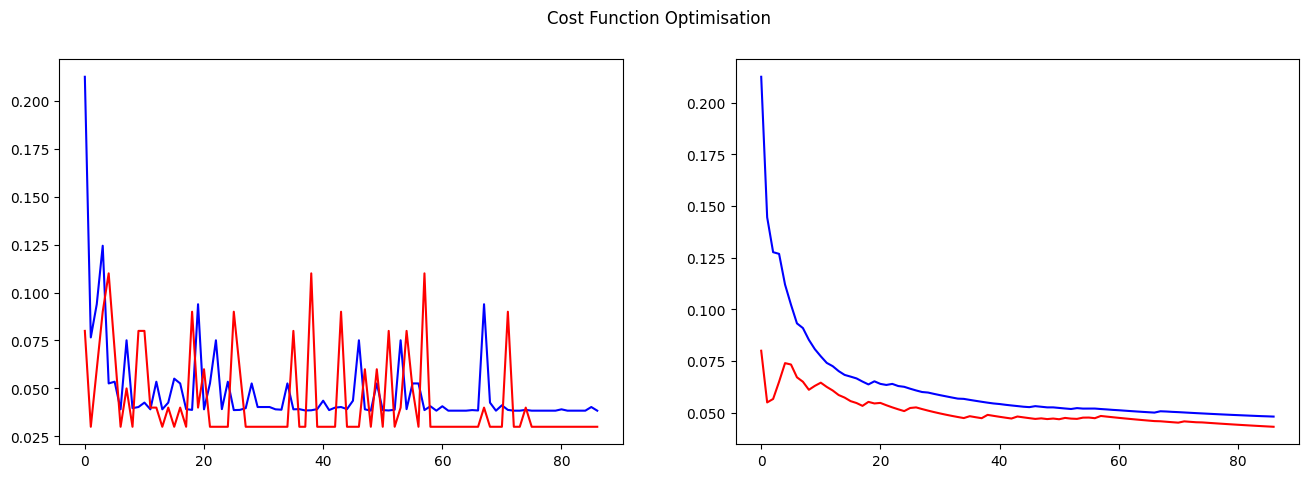

In [ ]:
def moving_avg(A):
    m = A[0]
    B = []
    B.append(m)
    for i in range(1,len(A)):
        m = (m * i + A[i])/(i+1)
        B.append(m)
    return B


xpoints = np.arange(out.nfev)
ypoints = np.array(progress)

y_av = moving_avg(ypoints)
zpoints = 1 - np.array(test_results)
z_av = moving_avg(zpoints)

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(xpoints, ypoints, color = 'b') 
axs[0].plot(xpoints, zpoints, color = 'r')

axs[1].plot(xpoints, y_av, color = 'b')
axs[1].plot(xpoints, z_av, color = 'r')

plt.suptitle('Cost Function Optimisation')
plt.show()

In [ ]:
remove_lines('progress.txt', keyword = name + '_cost_ema_b')
add_line('progress.txt', y_av, name + '_cost_ema_b')

remove_lines('progress.txt', keyword = name + '_accuracy_ema_b')
add_line('progress.txt', z_av, name + '_accuracy_ema_b')

Successfully added
Successfully added
